In [1]:
from segmented_comprehension import Image, Stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from natsort import natsorted
from tqdm import tqdm

In [6]:
root_directory='F:/my_data/Segmentation/'
server_directory='H:/Segmentation/'

In [5]:
stage_paths=natsorted(glob(root_directory+'JohnData/180930 star mdck 2mg col wt/segmented/WT_*'))
col_2mg=[Stack(stage_path) for stage_path in tqdm(stage_paths)]

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [12:29<00:00, 12.49s/it]


In [7]:
stage_paths=natsorted(glob(root_directory+'20240124 halo col_glass old_incubator/segmented/membrane-stage_*'))
col_glass_highdensity=[Stack(stage_path) for stage_path in tqdm(stage_paths)]

100%|██████████| 39/39 [01:09<00:00,  1.78s/it]


In [3]:
stage_paths=natsorted(glob(root_directory+'20240110 halo col_glass incubator/segmented/membrane-stage_*'))
col_glass=[Stack(stage_path) for stage_path in tqdm(stage_paths)]

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [09:35<00:00, 14.38s/it]


In [21]:
stage_paths=natsorted(glob(server_directory+'JohnData/180627 star mdck glass 2/segmented/WT_*'))
jd_glass=[Stack(stage_path) for stage_path in tqdm(stage_paths)]

100%|██████████████████████████████████████████████████████████████████████████████| 70/70 [56:57<00:00, 48.82s/it]


In [8]:
velocities=[]
for stack in tqdm(col_glass_highdensity):
    v=stack.get_velocities()
    v=v.merge(stack.shape_parameters(), on=['cell_number','frame'])
    velocities.append(v)

100%|██████████| 39/39 [24:47<00:00, 38.14s/it]


In [46]:
velocities=[]
for stack in tqdm(jd_glass):
    v=stack.get_velocities()
    v=v.merge(stack.shape_parameters(), on=['cell_number','frame'])
    velocities.append(v)

100%|████████████████████████████████████████████████████████████████████████████| 70/70 [1:17:19<00:00, 66.28s/it]


In [9]:
import pickle
with open('RAM_dump/colglass20240122_velocities.pkl', 'wb') as file:
    pickle.dump(velocities, file)

In [47]:
import pickle
with open('RAM_dump/John180627_velocities.pkl', 'wb') as file:
    pickle.dump(velocities, file)

In [16]:
import pickle
with open('RAM_dump/colglass20240122_velocities.pkl', 'rb') as file:
    velocities_highdensity=pickle.load(file)
with open('RAM_dump/colglass20240110_velocities.pkl', 'rb') as file:
    velocities_lowdensity=pickle.load(file)
with open('RAM_dump/John180627_velocities.pkl', 'rb') as file:
    velocities_jdglass=pickle.load(file)
with open('RAM_dump/John180930_velocities.pkl', 'rb') as file:
    velocities_jdcol=pickle.load(file)

In [22]:
jd_glass_densities=np.array([stack.densities() for stack in tqdm(jd_glass)])
glass_densities=np.array([stack.densities() for stack in tqdm(col_glass)])
high_density_densities=np.array([stack.densities() for stack in tqdm(col_glass_highdensity)])
col2mg_densities=np.array([stack.densities() for stack in tqdm(col_2mg)])

100%|██████████████████████████████████████████████████████████████████████████████| 70/70 [02:18<00:00,  1.98s/it]


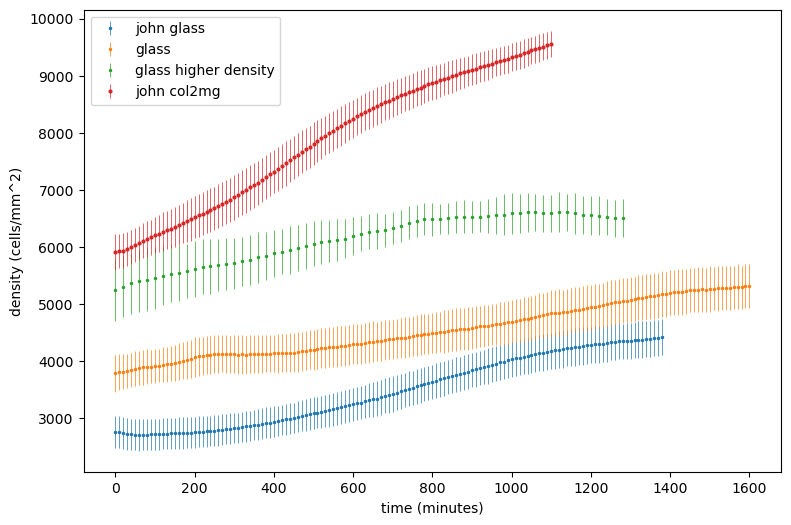

In [38]:
plt.figure(figsize=(9,6))
plt.errorbar(x=np.arange(jd_glass_densities.shape[1])*10,y=np.mean(jd_glass_densities, axis=0), yerr=np.std(jd_glass_densities,axis=0), fmt='.', markersize=3, linewidth=0.5, label='john glass')
plt.errorbar(x=np.arange(glass_densities.shape[1])*10,y=np.mean(glass_densities, axis=0), yerr=np.std(glass_densities,axis=0), fmt='.', markersize=3, linewidth=0.5, label='glass')
plt.errorbar(x=np.arange(high_density_densities.shape[1])*20,y=np.mean(high_density_densities, axis=0), yerr=np.std(high_density_densities,axis=0), fmt='.', markersize=3, linewidth=0.5, label='glass higher density')
plt.errorbar(x=np.arange(col2mg_densities.shape[1])*10,y=np.mean(col2mg_densities, axis=0), yerr=np.std(col2mg_densities,axis=0), fmt='.', markersize=4, linewidth=0.5, label='john col2mg')

plt.xlabel('time (minutes)')
plt.ylabel('density (cells/mm^2)')
plt.legend(loc='upper left')
plt.savefig('plots/mdck_growth_rates.jpg', dpi=300)

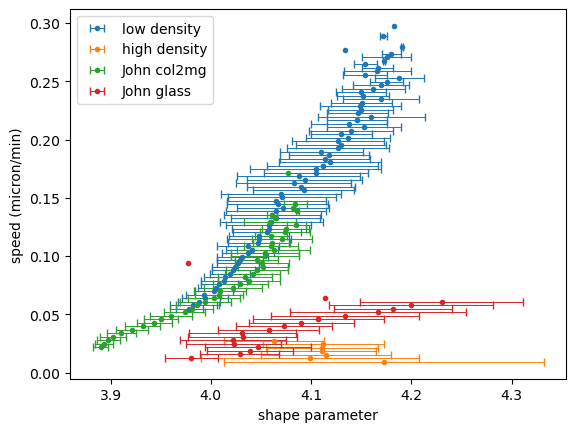

In [21]:
for velocities, label in zip([velocities_lowdensity, velocities_highdensity, velocities_jdcol, velocities_jdglass], ['low density', 'high density', 'John col2mg', 'John glass']):
    all_v=[]
    for v in velocities:
        all_v.append(v.groupby('frame')[['v','q']].mean())
    all_v=pd.concat(all_v)
    if label=='high density':
        time_interval=20
    else:
        time_interval=10

    all_v['v']*=6.45/20/time_interval
    bins=np.arange(all_v['v'].min(),0.3,0.003)

    all_v_binned=all_v.groupby(pd.cut(all_v['v'], bins=bins))['q'].agg([np.mean,np.std])
    bins=[interval.mid for interval in all_v_binned.index.values]

    plt.errorbar(all_v_binned['mean'], bins, xerr=all_v_binned['std'], fmt='.',capsize=3,linewidth=0.7, label=label)

plt.ylabel('speed (micron/min)')
plt.xlabel('shape parameter')
plt.legend()
plt.show()

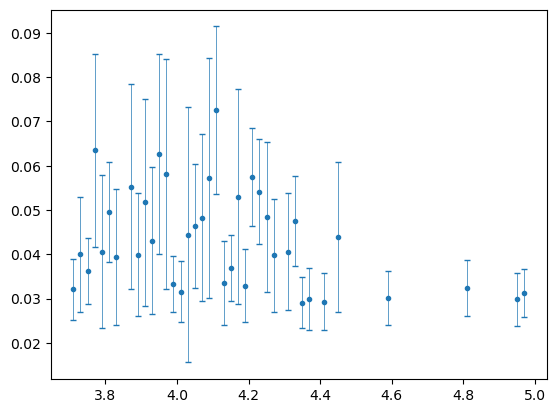

In [163]:
all_v_unavgd=pd.concat(velocities_glass)[['v','q']].reset_index(drop=True)
all_v_unavgd['v']*=6.45/20/10

bins=np.arange(3.7,5,0.02)

all_v_binned=all_v.groupby(pd.cut(all_v_unavgd['q'], bins=bins))['v'].agg(['mean','std'])
bins=[interval.mid for interval in all_v_binned.index.values]

plt.errorbar(bins, all_v_binned['mean'], yerr=all_v_binned['std'], fmt='.', capsize=2, linewidth=0.5)
#plt.scatter(all_v_unavgd['q'], all_v_unavgd['v'], s=1, alpha=0.1)
#plt.xlim(3.6,7)
#plt.ylim(-0.02,0.5)
plt.show()

(3.6, 5.0)

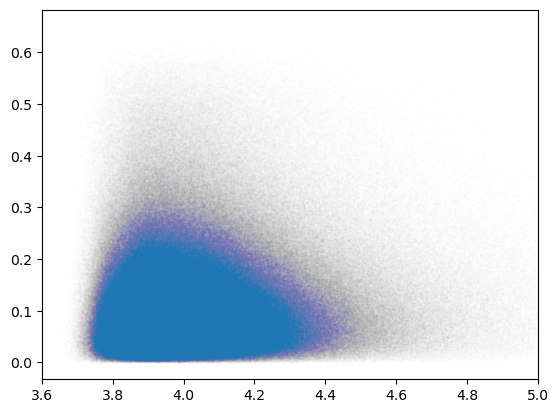

In [158]:
plt.scatter(all_v_unavgd['q'], all_v_unavgd['v'], s=0.1, alpha=0.01)
plt.xlim(3.6,5)

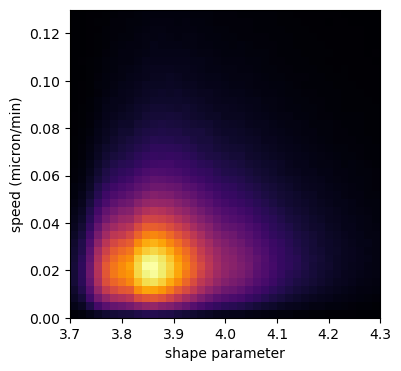

In [173]:
plt.figure(figsize=(4,4))
all_v_unavgd=pd.concat(velocities)[['v','q']]
all_v_unavgd['v']*=6.45/20/10
plt.hist2d(all_v_unavgd['q'], all_v_unavgd['v'], bins=[np.linspace(3.7,4.3,40), np.linspace(0,0.13,40)], cmap='inferno')

plt.xlabel('shape parameter')
plt.ylabel('speed (micron/min)')
plt.show()

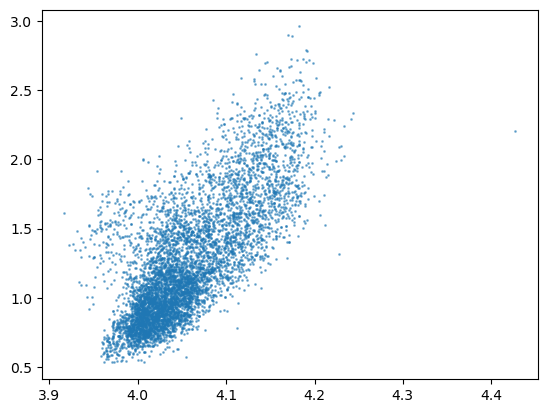

In [74]:
plt.scatter(all_v['q'], all_v['v'], alpha=0.5, s=1)

                    mean       std
v                                 
(0.204, 0.244]  3.890862  0.008001
(0.244, 0.284]  3.895282  0.010108
(0.284, 0.324]  3.901688  0.012915
(0.324, 0.364]  3.912193  0.014809
(0.364, 0.404]  3.927175  0.017514
(0.404, 0.444]  3.941357  0.017301
(0.444, 0.484]  3.952048  0.017919
(0.484, 0.524]  3.966624  0.020784
(0.524, 0.564]  3.980847  0.021407
(0.564, 0.604]  3.989603  0.023649
(0.604, 0.644]  3.997533  0.025725
(0.644, 0.684]  4.007046  0.024652
(0.684, 0.724]  4.010784  0.026655
(0.724, 0.764]  4.025525  0.027710
(0.764, 0.804]  4.037653  0.029446
(0.804, 0.844]  4.034238  0.027672
(0.844, 0.884]  4.045939  0.030229
(0.884, 0.924]  4.049707  0.023821
(0.924, 0.964]  4.050324  0.025953


<ErrorbarContainer object of 3 artists>

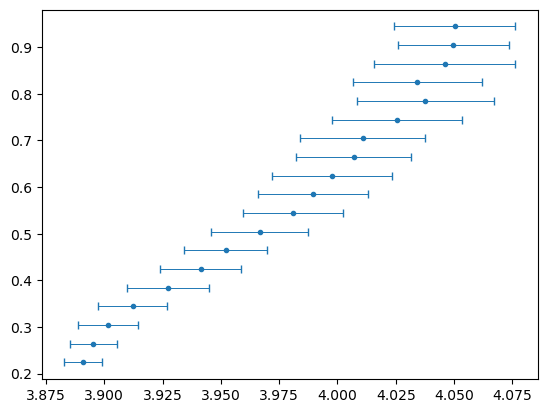

In [31]:
all_v=[]
for v in velocities:
    all_v.append(v.groupby('frame')[['v','q']].mean())
all_v=pd.concat(all_v)
all_v['v']*=6.45/20
bins=np.arange(all_v['v'].min(),1,0.04)

all_v_binned=all_v.groupby(pd.cut(all_v['v'], bins=bins))['q'].agg([np.mean,np.std])
print(all_v_binned)
bins=[interval.mid for interval in all_v_binned.index.values]

plt.errorbar(all_v_binned['mean'], bins, xerr=all_v_binned['std'], fmt='.',capsize=3,linewidth=0.7)

In [58]:
all_velocities=pd.concat(velocities)
av=all_velocities.groupby('frame')['v'].agg(['mean', 'std'])

In [72]:
import pickle
with open('RAM_dump/colglass20240110_velocities.pkl', 'wb') as file:
    pickle.dump(velocities, file)

In [67]:
import pickle
with open('RAM_dump/John180930_velocities.pkl', 'rb') as file:
    test=pickle.load(file)

<ErrorbarContainer object of 3 artists>

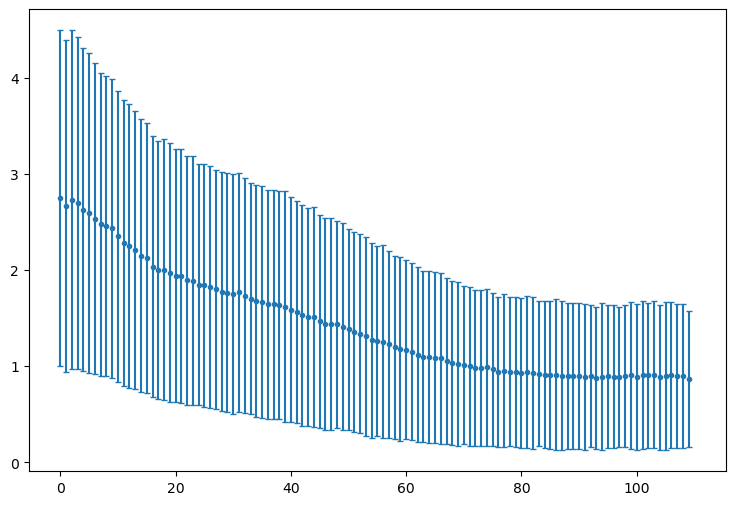

In [62]:
plt.figure(figsize=(9,6))
plt.errorbar(av.index, av['mean'], yerr=av['std'], fmt='.', capsize=2)